<a href="https://colab.research.google.com/github/nikhil00shinde/house-prediction/blob/main/House_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UNDERSTANDING 
 type(df) --> <class 'pandas.core.frame.DataFrame'>
 type(df['price']) --> <class 'pandas.core.series.Series'>
0     313000.0
1    2384000.0
2     342000.0
Name: price, dtype: float64
       price  bedrooms
0   313000.0       3.0
1  2384000.0       5.0
2   342000.0       3.0
Rows remaining: 4549
(4549, 20)
['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'city', 'statezip', 'sale_year', 'sale_month', 'house_age', 'was_renovated', 'years_since_update', 'sqft_total', 'has_basement']
(4549, 139)
bool       121
int64       12
float64      4
int32        2
Name: count, dtype: int64
Total OHE columns: 121

First 10:
['city_Algona', 'city_Auburn', 'city_Beaux Arts Village', 'city_Bellevue', 'city_Black Diamond', 'city_Bothell', 'city_Burien', 'city_Carnation', 'city_Clyde Hill', 'city_Covington']

 Rows 0 - which city/zip is it?
city_Shoreline       True
statezip_WA 98133    True
Name: 0, d

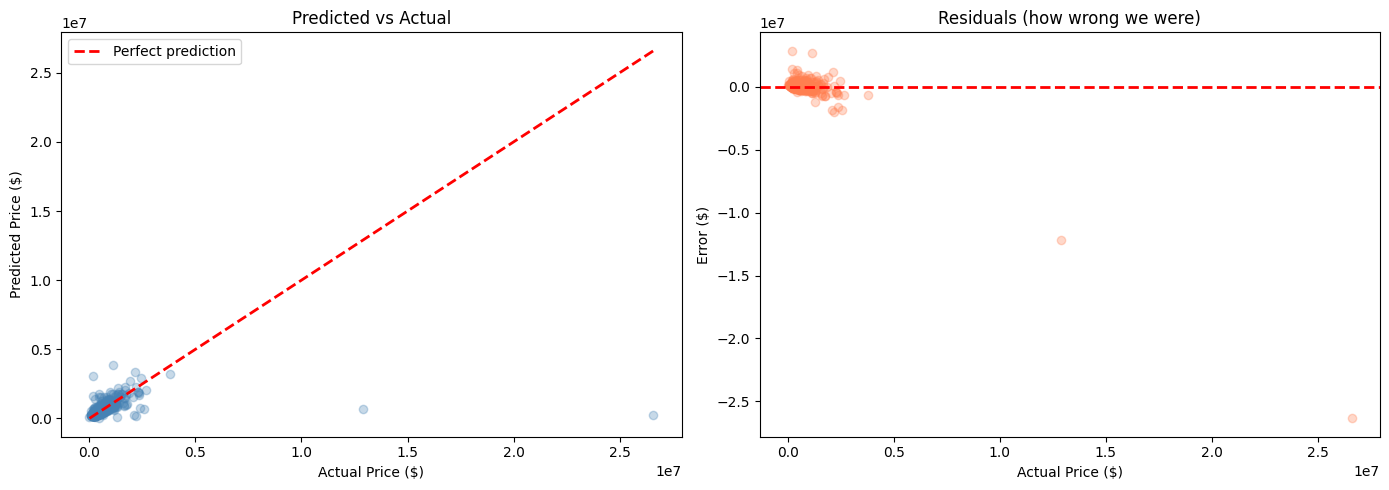

Saved!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("UNDERSTANDING ")
df = pd.read_csv("data.csv")
df['date'] = pd.to_datetime(df['date'])
print(f" type(df) --> {type(df)}")
print(f" type(df['price']) --> {type(df['price'])}")

print(df['price'].head(3))
print(df[["price","bedrooms"]].head(3))

# STEP 1: DROP BAD ROWS
df = df[df['price'] > 0]
df = df[df['bedrooms'] > 0]

print(f"Rows remaining: {len(df)}")


# STEP 2: FEATURE ENGINEERING
# extract year and month from sale date
df['date'] = pd.to_datetime(df['date'])
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month

# How old was the house when sold?
df['house_age'] = df['sale_year'] - df['yr_built']

# Was it ever renovated? (binary 0/1)
df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)

# If renovated, how many years ago? If never, use house_age
df['years_since_update'] = df.apply(
        lambda row: row['sale_year'] - row['yr_renovated']
        if row['yr_renovated'] > 0
        else row['house_age'],
        axis=1
)

# Total interior space
df['sqft_total'] = df['sqft_above']  +  df['sqft_basement']

# Does it have a basement?
df['has_basement'] = (df['sqft_basement'] > 0).astype(int)

# Drop columns we no longer need
df = df.drop(columns=['date','street','country','yr_built','yr_renovated'])

print(df.shape)
print(df.columns.tolist())
# Feature Engineering is translating your domain knowledge into math the model can use. The better your features, the less work has to do.




# STEP 3: Encode Categorical columns
# One-hot encode 'city' and 'statezip'

df = pd.get_dummies(df, columns=['city','statezip'],drop_first=False)

print(df.shape)
print(df.dtypes.value_counts())

# ONE HOT ENCODING: instead creates a binary column for each city:
# city    -->  city_seattle  city_Renton  city_Belleuve
# Seattle -->     1            0              0

# See all one-hot encoded columns
ohe_cols = [col for col in df.columns if col.startswith('city_') or col.startswith('statezip_')]
print(f"Total OHE columns: {len(ohe_cols)}")
print("\nFirst 10:")
print(ohe_cols[:10])

# See what is single row looks like for these columsn
print("\n Rows 0 - which city/zip is it?")
row = df[ohe_cols].iloc[0]
print(row[row == True]) # onlt show the 1s


# STEP 4: Normalize numeric features + fix dtypes
# Scale of numbers, Big numbers dominate, small numbers get ignored. Not because they're less important - just because they're smaller

# NORMALIZARTION: everyone gets the same scale, now compete farly
# Mean: is where you'd plant a flag in the middle of your data# Std: is how far most people are standing from the flag

# (X - mean) / std : How far is this value from normal, in units of spread? (Z-SCORE)

# First convert everything to float32
df = df.astype('float32')

# Separate target from features
y = np.log1p(df['price'].values) # log transform price
X = df.drop(columns=['price']).values # all other columns

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Manual normalization (Z-SCORE)
X_mean = X.mean(axis=0)  # one mean per column
X_std  = X.std(axis=0)   # one std per column
X_std[X_std == 0] = 1    # if a column never changes, don't divide by 0

X = (X - X_mean) / X_std

# Verify it worked
print(f"\nAfter normalization:")
print(f"X mean (should be ~0): {X.mean():.4f}")
print(f"X std  (should be ~1): {X.std() :.4f}")


# OUR INPUT X has shape (4549, 139) - 4549 houses, 139 features each
# The network will look like this:
# Input (139) -> Layer1(64) -> Layer2 (32) -> Output(1)


# output = activation(X @ weights + bias)
# @ is matrix multplication
# weights are what the model learns
# activation is a non-linear (we'll use ReLU)

import torch
import torch.nn as nn



# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (4549, 1)


print(f"X tensor: {X_tensor.shape}")
print(f"y tensor: {y_tensor.shape}")

# Define the neural network
class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.network = nn.Sequential(
                nn.Linear(input_size, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32,1)
                )

    def forward(self, x):
        return self.network(x)

model = HousePriceModel(input_size=X_tensor.shape[1])
print(f"\n Model architecture:")
print(model)

# Let calculate the parameters does this model have?
# Each linear layer has weights  + biases. Let's count:
# Layer 1: 138 * 64 + 64 = 8,896
# Layer 2:  64 * 32 + 32 = 2,080
# Layer 3:  32 * 1  +  1 =    33
# ------------------------------
# Total:                   11,009 parameters



# STEP 6: Train/test split and training loop:
from torch.utils.data import DataLoader, TensorDataset

# Split data - 80% train, 20% test
split = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


# DataLoader - feeds data in batchs during training
train_dataset = TensorDataset(X_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Lost function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() # reset gradients
        predictions = model(X_batch) # forward pass
        loss = criterion(predictions, y_batch) # compute loss
        loss.backward() # backpropagation
        optimizer.step() # update weights
        total_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1:3d}/100 - Loss: {avg_loss:.4f}")



# STEP 7: Evaluate on test set
model.eval() # turn off dropout/batchnorm (goodhabit even if we don't have them)


with torch.no_grad(): # don't compute gradients during evaluation
    y_pred_log = model(X_test)

# Convert predictions back from log scalte to real dollars
y_pred = np.expm1(y_pred_log.numpy().flatten())
y_true = np.expm1(y_test.numpy().flatten())

# RMSE - Root mean squares error
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

# MAE  - Mean Absolute error
mae  = np.mean(np.abs(y_pred - y_true))

# MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print(f"RMSE:  ${rmse:,.0f}")
print(f"MAE:   ${mae:,.0f}")
print(f"MAPE:  {mape:.1f}%")



# MAE --  Just take all errors, ignore the minus signs, average them.
# RMSE --  Square each error first, average them, then take sqaure root.
# Rule of thumb: If RMSE is much bigger than MAE, you have outliers your model is struggling with.
# MAPE - Express each error as a percentage of the actual price, then average.




# STEP 8: VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Plot 1: Predicted Vs Actual
axes[0].scatter(y_true, y_pred, alpha=0.3, color='steelblue')
axes[0].plot([y_true.min(), y_true.max()],
          [y_true.min(), y_true.max()],
          'r--', linewidth=2, label='Perfect prediction')

axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title('Predicted vs Actual')
axes[0].legend()

# Plot 2: Residual (errors)
residuals = y_pred - y_true
axes[1].scatter(y_true, residuals, alpha=0.3, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Error ($)')
axes[1].set_title('Residuals (how wrong we were)')

plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/evaluation.png', dpi=150)
plt.show()
print("Saved!")